# A. Business Understanding

Proyek Predictive Analytics: Prediksi Harga IHSG (^JKSE)
Mengikuti Metode CRISP-DM 6 Fase

Problem Steatment:
- IHSG (^JKSE) memiliki tingkat volatilitas yang tinggi, sehingga menyulitkan investor dan analis dalam memprediksi harga penutupan secara akurat, yang berdampak pada pengambilan keputusan investasi.
- Masih minim penelitian yang secara khusus mengeksplorasi dan membandingkan efektivitas berbagai pendekatan deep learning dalam menangani permasalahan prediksi harga penutupan IHSG. Terkhusus pada penerapan model deep learning seperti LSTM, CNN, dan GRU secara individual untuk memprediksi harga penutupan IHSG.

Goals:
- Menghasilkan model prediksi IHSG yang mampu mengurangi nilai error (MSE, RMSE MAE, MAPE, dan R2) dengan membandingkan model LSTM, CNN, dan GRU secara individual.
- Memberikan insight kuantitatif dan visual terhadap kemampuan masing-masing model dalam menangkap pola harga historis IHSG dan memprediksi harga di masa depan.

Solution statements:
- Mengimplementasikan dan melatih tiga model deep learning secara terpisah: LSTM, CNN, dan GRU menggunakan dataset historis harga penutupan IHSG (^JKSE).
- Mengukur performa setiap model menggunakan metrik kuantitatif yang objektif seperti Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), Mean absolute percentage error (MAPE), dan R-Squared (R2).

Untuk instalasi API, Framework, ataupun Library dapat dilakukan melalui file requirements.txt

## 1. Instalasi Library yang dibutuhkan

Perintah !pip install yfinance==0.2.54 adalah perintah untuk menginstal library yfinance dengan versi spesifik (0.2.54) menggunakan package manager pip dalam lingkup Python, perintah ini biasanya dijalankan di notebook seperti Jupyter Notebook atau Google Colab. dipilihnya versi 0.25.4 karena di versi itu data bisa di scrapping tanpa error


In [1]:
!pip install yfinance==0.2.54

## 2. Import Library yang akan digunakan

Berikut adalah penjelasan mengenai library yang digunakan pada baris kode dibawah:

- yfinance: Library untuk mengunduh data pasar saham dari Yahoo Finance.

- pandas: Library untuk manipulasi dan analisis data tabular.

- time: Library bawaan Python untuk operasi terkait waktu sistem.

- datetime: Library untuk manipulasi tanggal dan waktu.

- csv: Library untuk membaca dan menulis file CSV.

- os: Library untuk berinteraksi dengan sistem operasi.

- matplotlib: Library untuk membuat visualisasi data dasar.

- seaborn: Library visualisasi data statistik yang lebih estetis.

In [2]:
import yfinance as yf
import pandas as pd
import time
from datetime import datetime
import csv
import os
import matplotlib.pyplot as plt
import seaborn as sns

# B. Data Understanding

## 1. Mengambil data historis maksimal dari Yahoo Finance (Data Loading)

Kode berikut berfungsi untuk mengambil seluruh data historis indeks IHSG (Indeks Harga Saham Gabungan) dari Yahoo Finance sejak pertama kali tercatat hingga hari ini. Fungsi utama bernama fetch_jkse_historical() menggunakan library yfinance untuk mengakses data IHSG dengan kode ticker "^JKSE".

Dalam fungsi tersebut, data diambil dengan periode maksimum yang tersedia menggunakan method history(), kemudian diolah dengan mereset index DataFrame dan mengubah nama kolom 'Date' menjadi 'date' untuk konsistensi. Tanggal juga dikonversi dari format datetime menjadi string dengan format tahun-bulan-hari agar lebih mudah dibaca.

Pada bagian eksekusi utama (main block), kode mencoba menjalankan fungsi pengambilan data dan menyimpan hasilnya ke file CSV bernama "jkse_historical.csv" tanpa menyertakan index. Jika proses berhasil, akan ditampilkan pesan sukses beserta jumlah baris data yang diperoleh. Jika terjadi error selama proses, pesan error akan ditampilkan untuk membantu troubleshooting.

Kode ini bersifat standalone dan dapat dijalankan langsung sebagai script karena menggunakan pengecekan if __name__ == "__main__", yang memastikan bagian main hanya dieksekusi ketika file di-run langsung, bukan ketika diimpor sebagai module. Output utama dari kode ini adalah file CSV yang berisi seluruh data historis IHSG yang tersedia di Yahoo Finance.

In [3]:
def fetch_jkse_historical():
    """
    Mengambil seluruh data historis IHSG dari awal hingga hari ini.
    """
    ticker = yf.Ticker("^JKSE")

    # Ambil data maksimum yang tersedia (dari awal hingga hari ini)
    df = ticker.history(period="max", actions=False)

    # Reset index dan ubah format tanggal
    df = df.reset_index()
    df = df.rename(columns={'Date': 'date'})

    # Konversi tipe data datetime ke string (opsional)
    df['date'] = df['date'].dt.strftime('%Y-%m-%d')

    return df

if __name__ == "__main__":
    try:
        # Ambil data historis
        historical_data = fetch_jkse_historical()

        # Simpan ke CSV
        historical_data.to_csv("jkse_historical.csv", index=False)
        print(f"Data berhasil disimpan! Jumlah baris: {len(historical_data)}")

    except Exception as e:
        print(f"Terjadi error: {str(e)}")

Data berhasil disimpan! Jumlah baris: 8535


## 2. EDA - Deskripsi Variabel

Memuat dataset dari directory /Data :

In [4]:
maindf=pd.read_csv('/content/jkse_historical.csv')

Perintah maindf = pd.read_csv('/content/jkse_historical.csv') menggunakan library pandas (yang diimpor sebagai pd) untuk membaca data dari file CSV yang berlokasi di path /content/jkse_historical.csv dan menyimpannya ke dalam variabel maindf sebagai DataFrame pandas.

Menampilkan 5 data terbaru dan Terlama :

In [5]:
maindf

,date,Open,High,Low,Close,Volume
0,1990-04-06,641.244019,641.244019,641.244019,641.244019,0
1,1990-04-09,633.457336,633.457336,633.457336,633.457336,0
2,1990-04-10,632.061340,632.061340,632.061340,632.061340,0
3,1990-04-11,634.668274,634.668274,634.668274,634.668274,0
4,1990-04-12,639.589111,639.589111,639.589111,639.589111,0
...,...,...,...,...,...,...
8530,2025-04-14,6225.336914,6404.069824,6225.336914,6368.517090,149701700
8531,2025-04-15,6444.341797,6497.532227,6395.926758,6441.683105,147079600
8532,2025-04-16,6461.273926,6469.597168,6373.790039,6400.054199,142022700
8533,2025-04-17,6407.020996,6438.269043,6384.285156,6438.269043,131124200


maindf adalah sebuah DataFrame pandas yang berisi data historis IHSG (Indeks Harga Saham Gabungan) yang telah di-load dari file CSV (jkse_historical.csv), mencakup kolom-kolom seperti tanggal, harga (Open/High/Low/Close), dan volume perdagangan. Data yang ditampilkan adalah 5 data terbaru dan 5 data terlama

Menampilkan jumlah data dan feature pada dataset:

In [6]:
maindf.shape

(8535, 6)

maindf.shape adalah perintah dalam pandas yang menampilkan dimensi (jumlah baris dan kolom) dari DataFrame maindf dalam bentuk tuple (baris, kolom). Dalam kode diatas dataset berarti berisi 8534 data dengan 6 feature

Menampilkan informasi mengenai tipe data pada dataset:

In [7]:
maindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8535 entries, 0 to 8534
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    8535 non-null   object 
 1   Open    8535 non-null   float64
 2   High    8535 non-null   float64
 3   Low     8535 non-null   float64
 4   Close   8535 non-null   float64
 5   Volume  8535 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 400.2+ KB


Perintah maindf.info() dalam pandas digunakan untuk menampilkan ringkasan informasi tentang struktur dan kandungan DataFrame maindf, termasuk jumlah total entri (baris), daftar kolom beserta jumlah nilai non-null (tidak adal null) yang terkandung di dalamnya, tipe data masing-masing kolom (seperti float64 untuk numerik desimal, int64 untuk numerik bulat, atau object untuk teks/tanggal), serta estimasi penggunaan memori. Output ini membantu secara cepat mengevaluasi kualitas data - seperti mendeteksi missing values jika jumlah non-null tidak sesuai dengan total entri, memverifikasi kesesuaian tipe data, dan mengoptimalkan alokasi memori sebelum melakukan analisis lebih lanjut. Misalnya, untuk data IHSG, kita dapat memastikan kolom tanggal (date) bertipe object (string) atau sudah dikonversi ke datetime, serta mengecek konsistensi data harga (Open/High/Low/Close) dan volume perdagangan.

Menampilkan informasi mengenai Statistik Deskriptif data pada dataset:

In [8]:
maindf.describe()

,Open,High,Low,Close,Volume
count,8535.000000,8535.000000,8535.000000,8535.000000,8.535000e+03
mean,2814.285984,2829.873789,2796.542485,2814.085251,5.118739e+07
std,2474.594154,2486.571812,2460.743026,2473.515154,2.048066e+08
min,223.240311,223.240311,223.240311,223.240311,0.000000e+00
25%,504.601834,507.750229,500.262051,504.475342,2.724100e+06
50%,1781.983572,1792.152300,1770.499101,1783.909546,2.085050e+07
75%,5138.040906,5164.886486,5115.274943,5140.824951,5.377760e+07
max,7904.395020,7910.556152,7853.353027,7905.390137,9.788202e+09


Perintah maindf.describe() menghasilkan statistik deskriptif dari kolom numerik dalam DataFrame maindf, memberikan gambaran distribusi data seperti:

- count: Jumlah data valid (non-null)

- mean: Rata-rata nilai

- std: Standar deviasi (ukuran sebaran data)

- min/max: Nilai minimum dan maksimum

- quartil (25%, 50%, 75%): Batas distribusi data (median = 50%)

Kegunaan:
- Analisis Awal: Cek sebaran data (apakah ada outlier atau nilai ekstrem).

- Validasi Data: Bandingkan statistik dengan ekspektasi (misal: volume perdagangan tidak mungkin negatif).

- Persiapan Pemodelan: Pahami karakteristik data sebelum normalisasi/transformasi.

(Kolom non-numerik seperti date otomatis diabaikan.)

## 3. EDA - Menangani Missing Value dan Outliers

Fungsi handle_missing_values(df) dirancang untuk mengidentifikasi dan menangani missing values (data hilang) dalam DataFrame secara sistematis, khususnya untuk data time series seperti harga saham. Pertama, fungsi ini menampilkan jumlah missing values per kolom untuk memberikan gambaran awal. Jika ditemukan missing values, fungsi akan melakukan interpolasi linear terlebih dahulu karena metode ini cocok untuk data time series dengan mengisi nilai yang hilang berdasarkan pola data sekitarnya.

Jika masih ada missing values setelah interpolasi (misalnya di awal atau akhir dataset), fungsi akan menggunakan kombinasi forward-fill (mengisi dengan nilai terakhir yang valid) dan back-fill (mengisi dengan nilai berikutnya yang valid) sebagai cadangan. Fungsi ini juga memberikan laporan sebelum dan setelah penanganan untuk memastikan semua missing values telah teratasi, dan mengembalikan DataFrame yang sudah bersih (df_clean). Pendekatan bertahap ini memastikan kelengkapan data sambil mempertahankan karakteristik time series, yang penting untuk analisis finansial.

In [9]:
def handle_missing_values(df):
    print("\n=== Penanganan Missing Values ===")

    # Cek jumlah missing values
    print("\nMissing Values Sebelum Penanganan:")
    print(df.isnull().sum())

    # Handle missing values
    if df.isnull().sum().any():
        # Untuk data time series, gunakan interpolasi (https://medium.com/@aseafaldean/time-series-data-interpolation-e4296664b86)
        df_clean = df.interpolate(method='linear')
        print("\nMissing values diatasi dengan interpolasi linear")

        #Jika masih ada missing value setelah interpolasi
        if df_clean.isnull().sum().any():
          df_clean = df_clean.ffill().bfill()
          print("\nSisa Missing values diatasi dengan forward-fill dan back-fill")
    else:
        df_clean = df.copy()
        print("\nTidak ada missing values")

    # Verifikasi setelah penanganan
    print("\nMissing Values Setelah Penanganan:")
    print(df_clean.isnull().sum())

    return df_clean

# Contoh penggunaan
maindf_cleaned = handle_missing_values(maindf)


=== Penanganan Missing Values ===

Missing Values Sebelum Penanganan:
date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Tidak ada missing values

Missing Values Setelah Penanganan:
date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


Tampilkan data setelah penanganan missing values:

In [10]:
maindf_cleaned

,date,Open,High,Low,Close,Volume
0,1990-04-06,641.244019,641.244019,641.244019,641.244019,0
1,1990-04-09,633.457336,633.457336,633.457336,633.457336,0
2,1990-04-10,632.061340,632.061340,632.061340,632.061340,0
3,1990-04-11,634.668274,634.668274,634.668274,634.668274,0
4,1990-04-12,639.589111,639.589111,639.589111,639.589111,0
...,...,...,...,...,...,...
8530,2025-04-14,6225.336914,6404.069824,6225.336914,6368.517090,149701700
8531,2025-04-15,6444.341797,6497.532227,6395.926758,6441.683105,147079600
8532,2025-04-16,6461.273926,6469.597168,6373.790039,6400.054199,142022700
8533,2025-04-17,6407.020996,6438.269043,6384.285156,6438.269043,131124200


maindf_cleaned merupakan versi DataFrame yang telah dibersihkan dari missing values melalui proses interpolasi linear (untuk mengisi celah data berdasarkan pola sekitarnya) dan fallback forward-fill/back-fill (jika interpolasi tidak mencukupi), dihasilkan dari fungsi handle_missing_values() yang sebelumnya mengecek dan menangani nilai kosong secara sistematis - fungsi ini terlebih dahulu menampilkan jumlah missing values awal, melakukan penanganan bertahap, lalu memverifikasi hasilnya dengan menampilkan laporan akhir yang memastikan tidak ada lagi nilai kosong, sehingga DataFrame ini sekarang siap untuk analisis lebih lanjut seperti perhitungan indikator teknikal atau pemodelan prediktif tanpa gangguan data hilang, sementara tetap mempertahankan struktur asli dan karakteristik time series data finansial tersebut.

##Melakukan proses IQR untuk mengatasi outlier

In [11]:
def handle_outliers(df, column):
    print(f"\n=== Penanganan Outliers pada kolom '{column}' ===")

    # Metode IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"Jumlah outliers: {len(outliers)}")

    # Winsorizing (Batas atas/bawah diganti dengan batas IQR) https://www.stat.cmu.edu/~hseltman/309/Book/Book.pdf halaman 70
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    print("Outliers ditangani dengan Winsorizing")

    return df

# Contoh penggunaan untuk beberapa kolom (sesuaikan dengan kolom yang ingin diproses)
columns_to_check = ['Open', 'High', 'Low', 'Close', 'Volume']
for col in columns_to_check:
    maindf_cleaned = handle_outliers(maindf_cleaned, col)


=== Penanganan Outliers pada kolom 'Open' ===
Jumlah outliers: 0
Outliers ditangani dengan Winsorizing

=== Penanganan Outliers pada kolom 'High' ===
Jumlah outliers: 0
Outliers ditangani dengan Winsorizing

=== Penanganan Outliers pada kolom 'Low' ===
Jumlah outliers: 0
Outliers ditangani dengan Winsorizing

=== Penanganan Outliers pada kolom 'Close' ===
Jumlah outliers: 0
Outliers ditangani dengan Winsorizing

=== Penanganan Outliers pada kolom 'Volume' ===
Jumlah outliers: 1023
Outliers ditangani dengan Winsorizing


Fungsi **handle_outliers(df, column)** dirancang untuk mendeteksi dan menangani outliers pada kolom tertentu dalam DataFrame menggunakan metode IQR (Interquartile Range), di mana pertama-tama dihitung kuartil bawah (Q1) dan kuartil atas (Q3) untuk menentukan batas bawah (lower_bound = Q1 - 1.5 * IQR) dan batas atas (upper_bound = Q3 + 1.5 * IQR), kemudian mengidentifikasi outliers sebagai nilai yang berada di luar rentang ini. Setelah menampilkan jumlah outliers yang ditemukan, fungsi ini menerapkan teknik winsorizing dengan mengganti nilai outliers yang terdeteksi menggunakan metode clip() untuk membatasi nilai-nilai ekstrem tersebut agar tidak melebihi batas IQR yang telah ditentukan, sehingga distribusi data menjadi lebih stabil tanpa menghilangkan seluruh baris yang mengandung outliers. Contoh penggunaan fungsi ini dilakukan secara iteratif pada kolom-kolom penting seperti 'Open', 'High', 'Low', 'Close', dan 'Volume' dari DataFrame maindf_cleaned yang sebelumnya telah dibersihkan dari missing values, sehingga menghasilkan data yang lebih konsisten dan siap untuk analisis lebih lanjut seperti pemodelan statistik atau visualisasi tanpa distorsi oleh nilai-nilai ekstrem. Outliers ditemukan pada Feature volume dan segera dibersihkan

Tampilkan data setelah penanganan outlier:

In [12]:
maindf_cleaned

,date,Open,High,Low,Close,Volume
0,1990-04-06,641.244019,641.244019,641.244019,641.244019,0
1,1990-04-09,633.457336,633.457336,633.457336,633.457336,0
2,1990-04-10,632.061340,632.061340,632.061340,632.061340,0
3,1990-04-11,634.668274,634.668274,634.668274,634.668274,0
4,1990-04-12,639.589111,639.589111,639.589111,639.589111,0
...,...,...,...,...,...,...
8530,2025-04-14,6225.336914,6404.069824,6225.336914,6368.517090,130357850
8531,2025-04-15,6444.341797,6497.532227,6395.926758,6441.683105,130357850
8532,2025-04-16,6461.273926,6469.597168,6373.790039,6400.054199,130357850
8533,2025-04-17,6407.020996,6438.269043,6384.285156,6438.269043,130357850


*(DataFrame ini merupakan versi lebih "bersih" dari maindf asli yang siap digunakan untuk analisis lanjutan.)*

Visualisasi data 'Open' setelah penanganan outliers

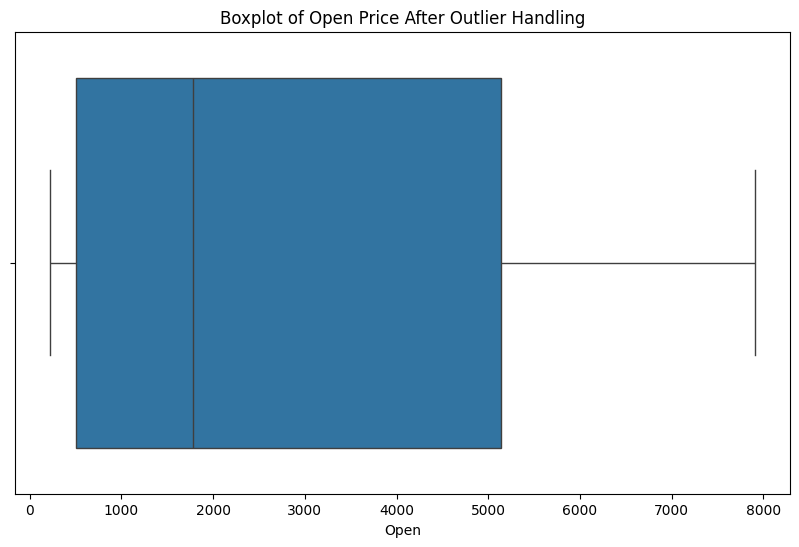

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=maindf_cleaned['Open'])
plt.title('Boxplot of Open Price After Outlier Handling')
plt.show()

*boxplot diatas membuktikan bahwa data pada feature **open** sudah bersih dan tidak ada missing value ataupun outliers karena sudah dilakukan proses pembersihan sebelumnya*

Visualisasi data 'Close' setelah penanganan outliers

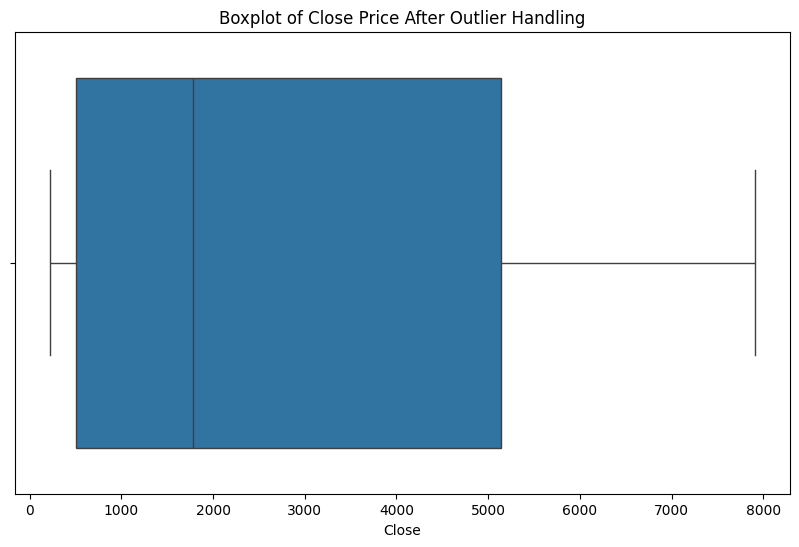

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=maindf_cleaned['Close'])
plt.title('Boxplot of Close Price After Outlier Handling')
plt.show()

*boxplot diatas membuktikan bahwa data pada feature **close** sudah bersih dan tidak ada missing value ataupun outliers karena sudah dilakukan proses pembersihan sebelumnya*

Visualisasi data 'High' setelah penanganan outliers

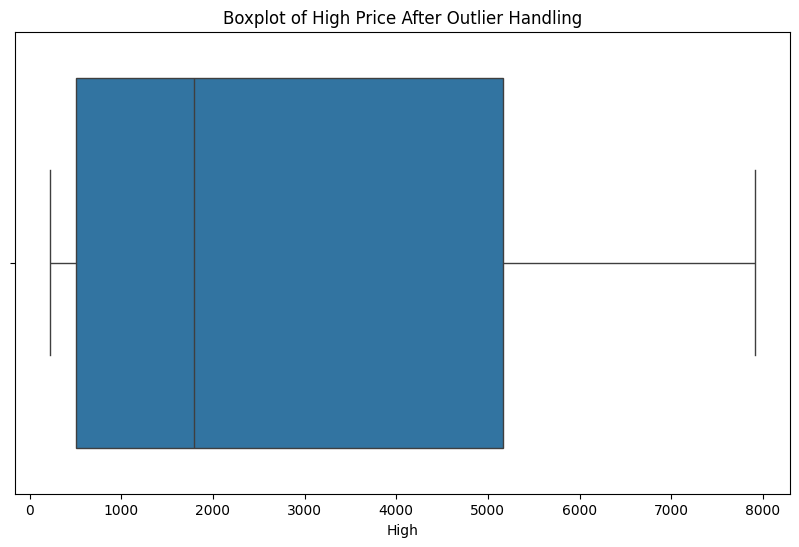

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=maindf_cleaned['High'])
plt.title('Boxplot of High Price After Outlier Handling')
plt.show()

*boxplot diatas membuktikan bahwa data pada feature **high** sudah bersih dan tidak ada missing value ataupun outliers karena sudah dilakukan proses pembersihan sebelumnya*

Visualisasi data 'Low' setelah penanganan outliers

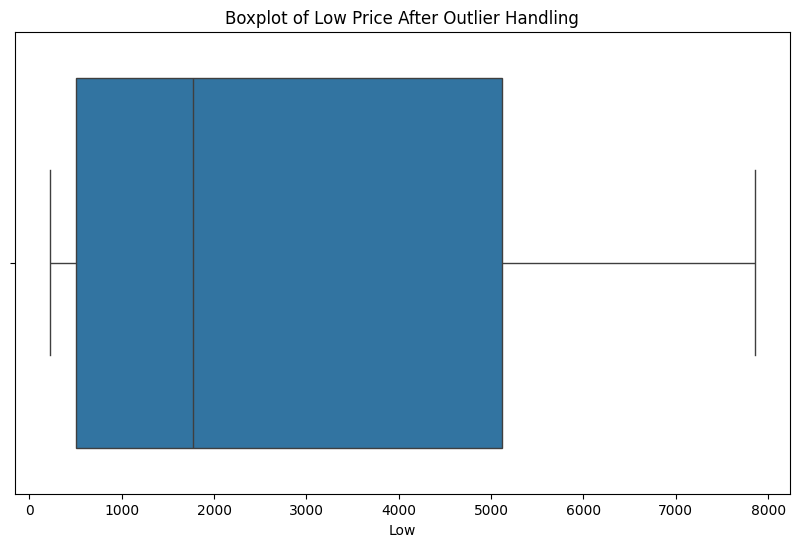

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=maindf_cleaned['Low'])
plt.title('Boxplot of Low Price After Outlier Handling')
plt.show()

*boxplot diatas membuktikan bahwa data pada feature **low** sudah bersih dan tidak ada missing value ataupun outliers karena sudah dilakukan proses pembersihan sebelumnya*

Visualisasi data 'Volume' setelah penanganan outliers

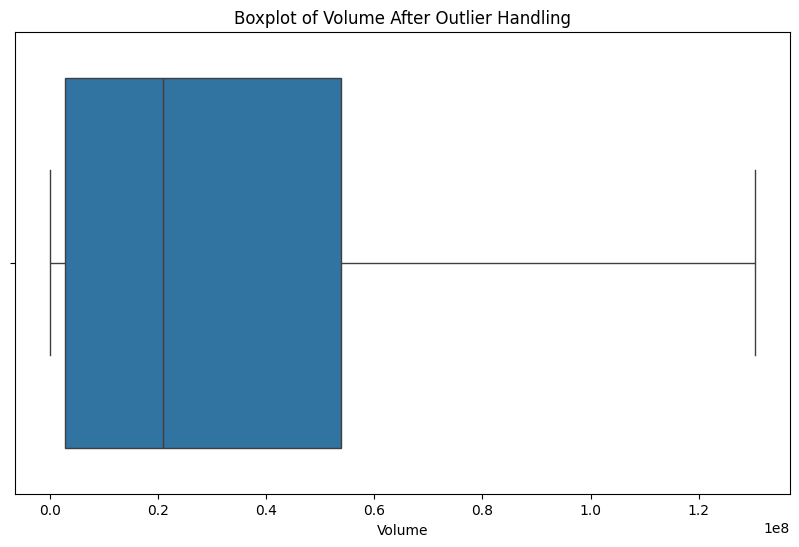

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=maindf_cleaned['Volume'])
plt.title('Boxplot of Volume After Outlier Handling')
plt.show()

*boxplot diatas membuktikan bahwa data pada feature **volume** sudah bersih dan tidak ada missing value ataupun outliers karena sudah dilakukan proses pembersihan sebelumnya*

Visualisasi data 'Open', 'Close', 'High', 'Low', dan 'Volume' setelah penanganan outliers dalam boxplot

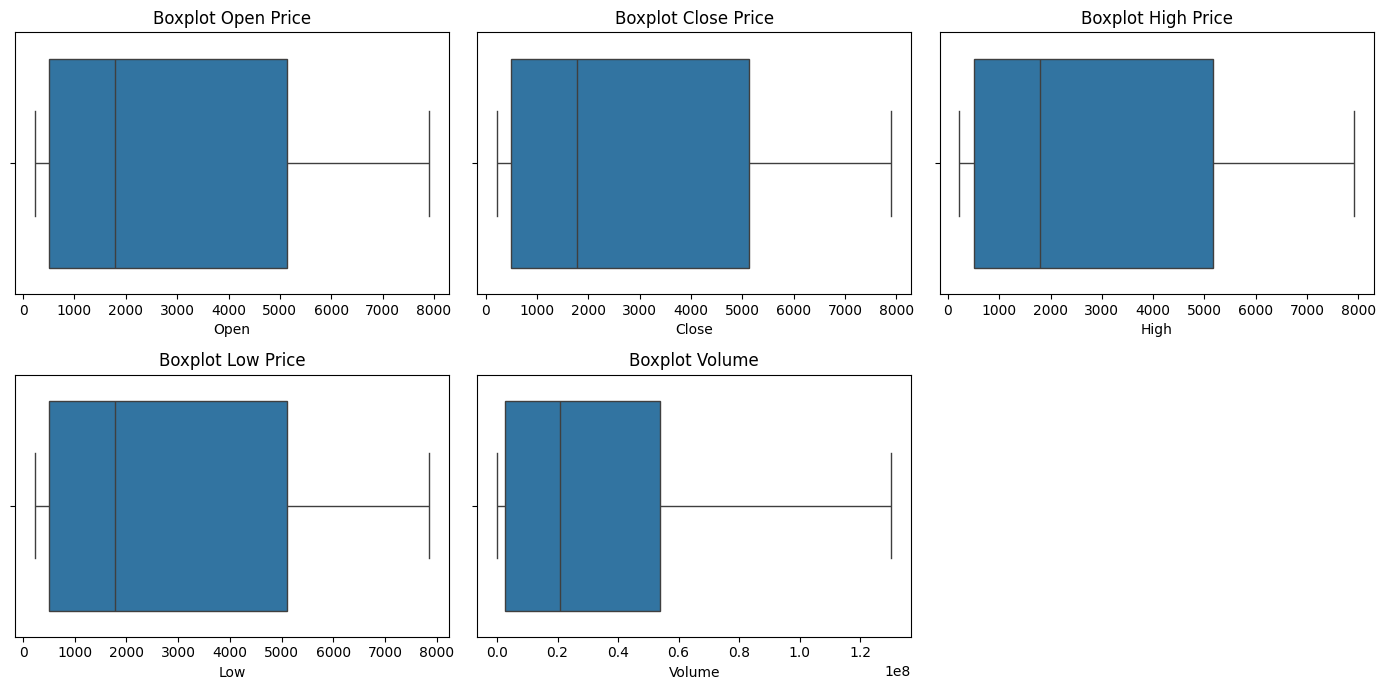

In [18]:
plt.figure(figsize=(14, 7))

plt.subplot(2, 3, 1)
sns.boxplot(x=maindf_cleaned['Open'])
plt.title('Boxplot Open Price')

plt.subplot(2, 3, 2)
sns.boxplot(x=maindf_cleaned['Close'])
plt.title('Boxplot Close Price')

plt.subplot(2, 3, 3)
sns.boxplot(x=maindf_cleaned['High'])
plt.title('Boxplot High Price')

plt.subplot(2, 3, 4)
sns.boxplot(x=maindf_cleaned['Low'])
plt.title('Boxplot Low Price')

plt.subplot(2, 3, 5)
sns.boxplot(x=maindf_cleaned['Volume'])
plt.title('Boxplot Volume')

plt.tight_layout()
plt.show()

*Gambar diatas adalah sama dengan 5 gambar sebelumnya namun dijadikan 1 agar lebih mempermudah pem**baca**annya*

## 4. EDA - Univariate Analysis

Univariate Analysis - Histograms untuk seluruh feature

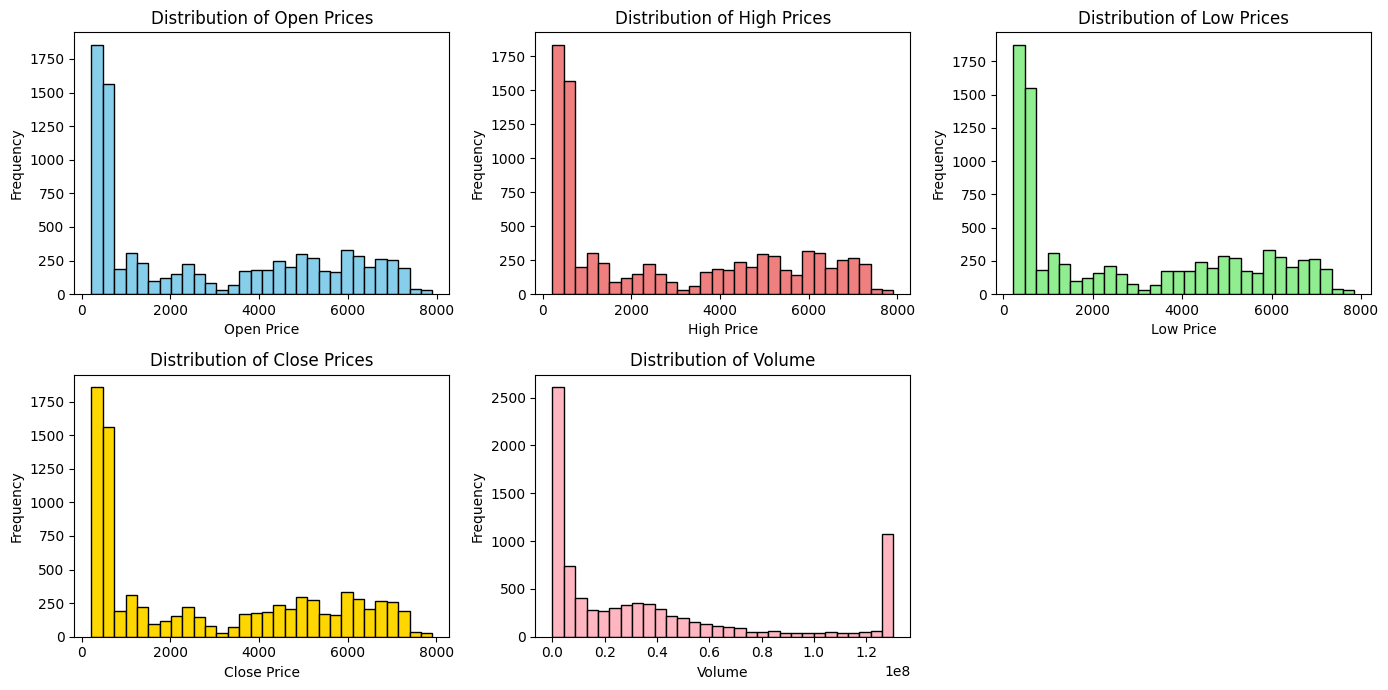

In [19]:
plt.figure(figsize=(14, 7))

# Histogram 'Open'
plt.subplot(2, 3, 1)
plt.hist(maindf_cleaned['Open'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Open Prices')
plt.xlabel('Open Price')
plt.ylabel('Frequency')

# Histogram 'High'
plt.subplot(2, 3, 2)
plt.hist(maindf_cleaned['High'], bins=30, color='lightcoral', edgecolor='black')
plt.title('Distribution of High Prices')
plt.xlabel('High Price')
plt.ylabel('Frequency')

# Histogram 'Low'
plt.subplot(2, 3, 3)
plt.hist(maindf_cleaned['Low'], bins=30, color='lightgreen', edgecolor='black')
plt.title('Distribution of Low Prices')
plt.xlabel('Low Price')
plt.ylabel('Frequency')

# Histogram 'Close'
plt.subplot(2, 3, 4)
plt.hist(maindf_cleaned['Close'], bins=30, color='gold', edgecolor='black')
plt.title('Distribution of Close Prices')
plt.xlabel('Close Price')
plt.ylabel('Frequency')

# Histogram 'Volume'
plt.subplot(2, 3, 5)
plt.hist(maindf_cleaned['Volume'], bins=30, color='lightpink', edgecolor='black')
plt.title('Distribution of Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Terlihat pada gambar diatas bahwa distribusi data pada keseluruhan(5) Feature terdapat perbedaan. Untuk open, high, low, close memiliki rentang nilai yang sama sedangkan volume memiliki nilai distribusi yang berbeda sendiri.

**KEPUTUSAN UNTUK DROP FEATURE VOLUME AKAN DILAKUKAN PADA PROSES-PROSES SETELAHNYA**

Menampilkan Density Plots

<ipython-input-20-2d05a322e095>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(maindf_cleaned['Open'], shade=True, color='skyblue')
<ipython-input-20-2d05a322e095>:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(maindf_cleaned['High'], shade=True, color='lightcoral')
<ipython-input-20-2d05a322e095>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(maindf_cleaned['Low'], shade=True, color='lightgreen')
<ipython-input-20-2d05a322e095>:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(maindf_cleaned

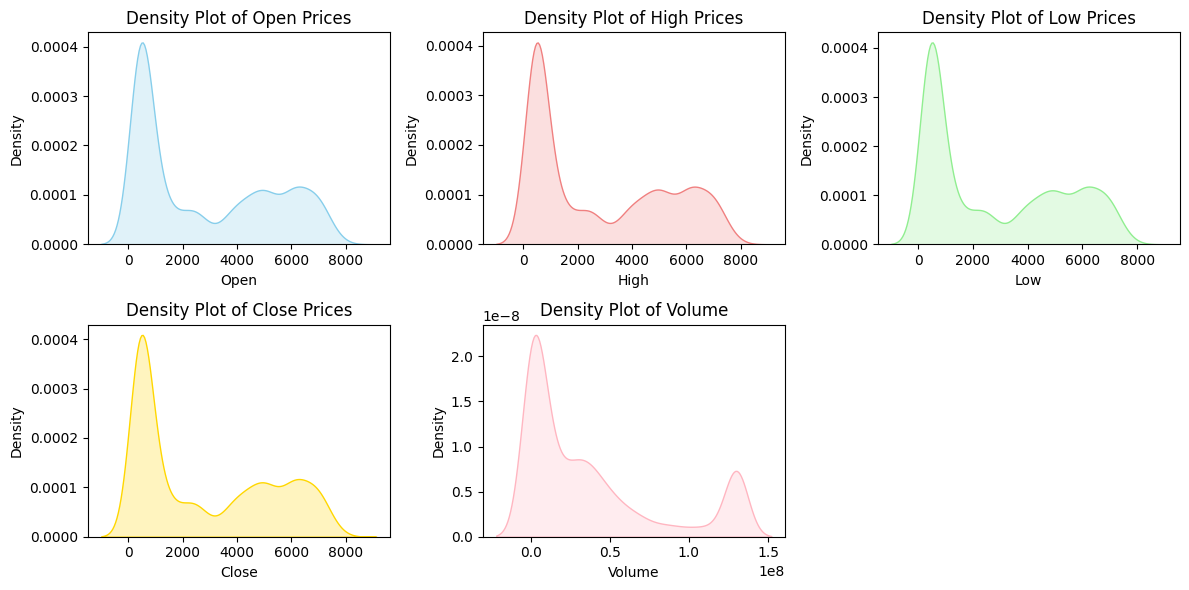

In [20]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
sns.kdeplot(maindf_cleaned['Open'], shade=True, color='skyblue')
plt.title('Density Plot of Open Prices')

plt.subplot(2, 3, 2)
sns.kdeplot(maindf_cleaned['High'], shade=True, color='lightcoral')
plt.title('Density Plot of High Prices')

plt.subplot(2, 3, 3)
sns.kdeplot(maindf_cleaned['Low'], shade=True, color='lightgreen')
plt.title('Density Plot of Low Prices')

plt.subplot(2, 3, 4)
sns.kdeplot(maindf_cleaned['Close'], shade=True, color='gold')
plt.title('Density Plot of Close Prices')

plt.subplot(2, 3, 5)
sns.kdeplot(maindf_cleaned['Volume'], shade=True, color='lightpink')
plt.title('Density Plot of Volume')

plt.tight_layout()
plt.show()


Sama seperti pada histogram, terlihat pada gambar diatas bahwa density data pada keseluruhan(5) Feature terdapat perbedaan. Untuk open, high, low, close memiliki rentang nilai yang sama sedangkan volume memiliki nilai pola density yang berbeda sendiri.

**KEPUTUSAN UNTUK DROP FEATURE VOLUME AKAN DILAKUKAN PADA PROSES-PROSES SETELAHNYA**

Visualisasikan Close Price Time Series

<ipython-input-21-1c4d5c78b011>:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = maindf_cleaned['Close'].resample('M').mean()


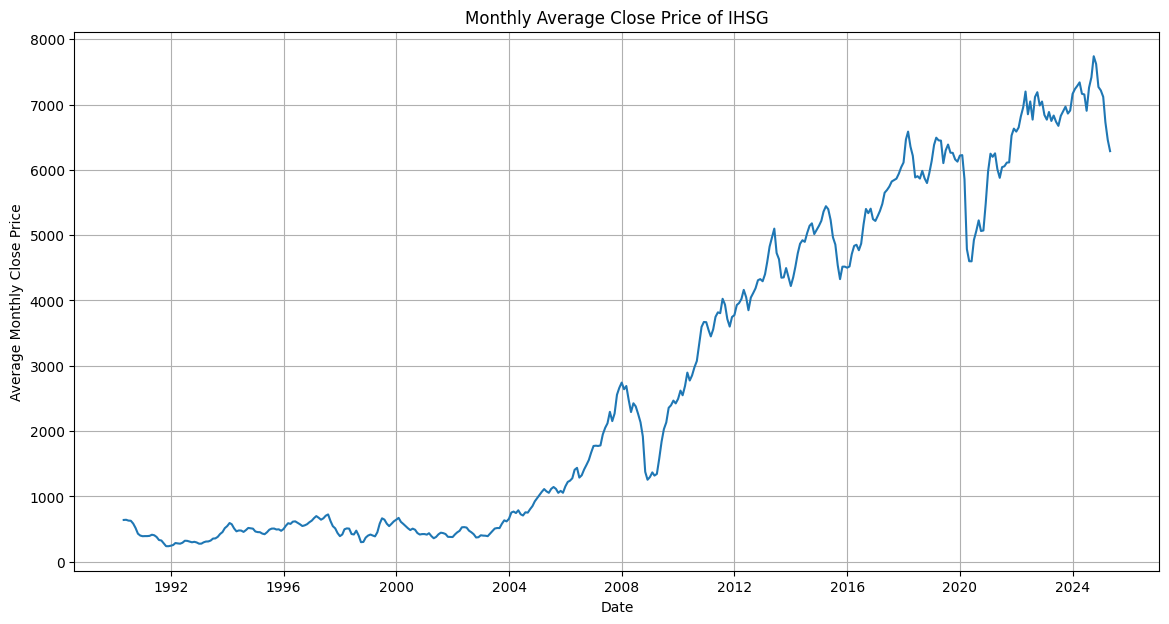

In [21]:
maindf_cleaned['date'] = pd.to_datetime(maindf_cleaned['date'])

# Set 'date' as index
maindf_cleaned = maindf_cleaned.set_index('date')

# Resample to monthly frequency and take the mean of 'Close' price
monthly_data = maindf_cleaned['Close'].resample('M').mean()

# Create the plot
plt.figure(figsize=(14, 7))
plt.plot(monthly_data.index, monthly_data.values)
plt.xlabel("Date")
plt.ylabel("Average Monthly Close Price")
plt.title("Monthly Average Close Price of IHSG")
plt.grid(True)
plt.show()

Gambar diatas adalah bentuk pola time series dari dataset IHSG sejak 1990 hingga hari ini, dapat dilihat juga pola serta fluktiasinya yang cukup tinggi.

Menampilkan Descriptive Statistics

In [22]:
maindf_cleaned.describe()

,Open,High,Low,Close,Volume
count,8535.000000,8535.000000,8535.000000,8535.000000,8.535000e+03
mean,2814.285984,2829.873789,2796.542485,2814.085251,3.796068e+07
std,2474.594154,2486.571812,2460.743026,2473.515154,4.421105e+07
min,223.240311,223.240311,223.240311,223.240311,0.000000e+00
25%,504.601834,507.750229,500.262051,504.475342,2.724100e+06
50%,1781.983572,1792.152300,1770.499101,1783.909546,2.085050e+07
75%,5138.040906,5164.886486,5115.274943,5140.824951,5.377760e+07
max,7904.395020,7910.556152,7853.353027,7905.390137,1.303578e+08


Statistik Deskriptif diatas pada dasarnya sama seperti Statistik Deskriptif pada tahap **EDA - Deskripsi Variabel**, akan tetapi jumlah angkanya akan sedikit berubah karena sudah dilakukan proses penghilangan missing value dan penghilangan outliers

## 5. EDA - Multivariate Analysis

Melakukan Correlation Matrix

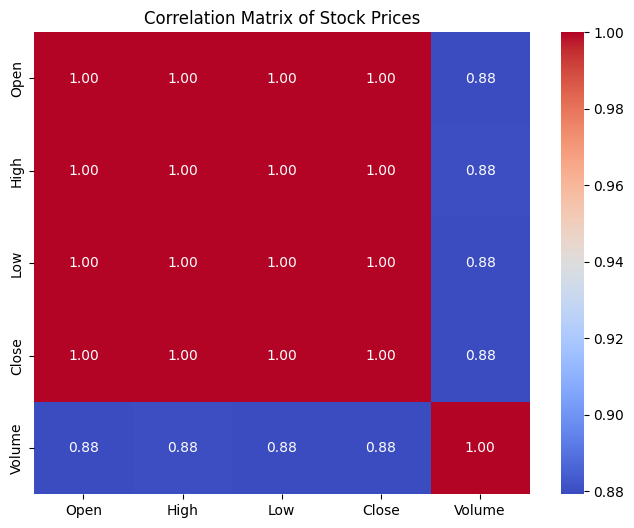

In [23]:
correlation_matrix = maindf_cleaned[['Open', 'High', 'Low', 'Close', 'Volume']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Stock Prices')
plt.show()

Pada Correlation Matrix diatas terlihat sangat amat jelas bahwa feature close, low, high, dan open memiliki perbedaan yang hampir **TIDAK ADA** sedangkan volume yang berbeda sendiri dengan angka yang jauh berbeda. Hal ini membuktikan bahwa korelasi antara feature volume dengan feature lainnya berbeda sehingga dapat di buang (**DROP**) di proses-proses selanjutnya.

Menampilkan Scatter Plots

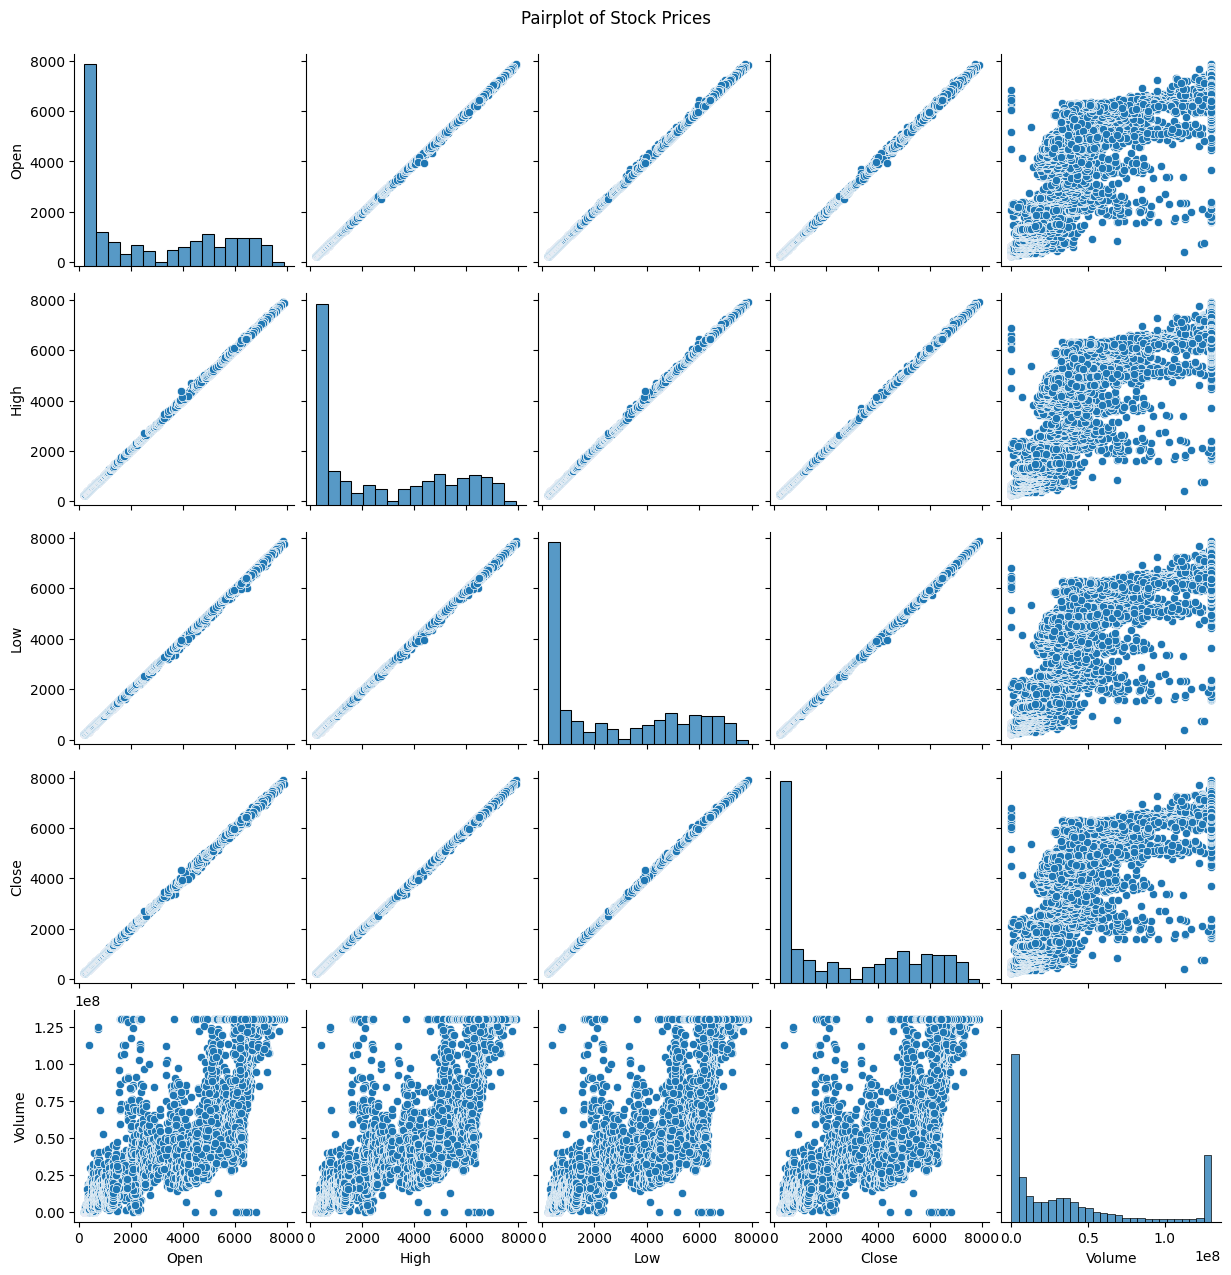

In [24]:
sns.pairplot(maindf_cleaned[['Open', 'High', 'Low', 'Close', 'Volume']])
plt.suptitle('Pairplot of Stock Prices', y=1.02)
plt.show()

Kesimpulan:
1. **Karena Volume tidak memiliki korelasi yang kuat dengan data lainnya maka tidak dipilih**. (DROP)
2. **Close yang akan dipilih karena dari keempat parameter lainnya hasilnya hampir sama**.

# C. Data Preparation

## 1. Encoding data dan pilih Feature Date dan Close

In [25]:
# Select 'date' and 'Close' columns
close_stock = maindf_cleaned.copy()
# Reset the index to get 'date' back as a column
selected_data = maindf_cleaned.reset_index()[['date', 'Close']]
selected_data

,date,Close
0,1990-04-06,641.244019
1,1990-04-09,633.457336
2,1990-04-10,632.061340
3,1990-04-11,634.668274
4,1990-04-12,639.589111
...,...,...
8530,2025-04-14,6368.517090
8531,2025-04-15,6441.683105
8532,2025-04-16,6400.054199
8533,2025-04-17,6438.269043


Berdasarkan proses EDA, feature yang akan dipilih dan dijadikan untuk testing serta training adalah feature close. Kemudian kelima data awal dan akhir dari feature date dan close akan ditampilkan seperti pada tabel diatas.

**ANDA BISA MEMBACA LAGI PADA TAHAPAN "EDA - Multivariate Analysis" KENAPA FEATURE CLOSE YANG DIPILIH**

kemudian pilih 1000 data terbaru untuk data test dan data train

In [26]:
maindf_cleaned_split = selected_data[-1000:]
maindf_cleaned_split

,date,Close
7535,2021-02-24,6251.054199
7536,2021-02-25,6289.645996
7537,2021-02-26,6241.795898
7538,2021-03-01,6338.513184
7539,2021-03-02,6359.205078
...,...,...
8530,2025-04-14,6368.517090
8531,2025-04-15,6441.683105
8532,2025-04-16,6400.054199
8533,2025-04-17,6438.269043


Kenapa hanya 1000 data terbaru yang dipilih untuk training dan testing??

Saya hanya memilih 1000 data terbaru agar kinerja model tetap optimal dan tidak terbebani, karena beberapa model yang saya gunakan tidak mampu membaca data time series yang sangat panjang.

## 2. Bagi data kedalam data train (80%) dan data test (20%)

In [27]:
from sklearn.model_selection import train_test_split

# Select features (Close only)
selected_data = maindf_cleaned_split[['Close']]

# Split the data into training and testing sets (80:20)
train_data, test_data = train_test_split(selected_data, test_size=0.2, random_state=42, shuffle=False)  # Important: shuffle=False for time series data

# Now you have train_data and test_data
print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)

Training data shape: (800, 1)
Testing data shape: (200, 1)


Baris kode diatas adalah proses untuk melakukan persiapan data time series dengan memilih hanya kolom 'Close' (harga penutupan) sebagai fitur, kemudian membagi data menjadi training set (80%) dan testing set (20%) menggunakan **train_test_split** dari **scikit-learn**. Parameter **shuffle=False** sangat penting karena menjaga urutan kronologis data, mencegah kebocoran informasi dari masa depan ke masa lalu, yang dapat merusak evaluasi model time series. **random_state=42** memastikan hasil yang konsisten, output akhir menampilkan dimensi dari training dan testing set untuk memverifikasi proporsi pembagian data.

## 3. Standarisasi menggunakan metode Min-Max Scaler

In [28]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler to the training data and transform both training and testing data
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# You can convert them back to dataframes if needed:
train_data_scaled = pd.DataFrame(train_data_scaled, columns=['Close'], index=train_data.index)
test_data_scaled = pd.DataFrame(test_data_scaled, columns=['Close'], index=test_data.index)

print("Scaled Training data shape:", train_data_scaled.shape)
print("Scaled Testing data shape:", test_data_scaled.shape)

Scaled Training data shape: (800, 1)
Scaled Testing data shape: (200, 1)


Proses diatas merupakan proses normalisasi data time series menggunakan **MinMaxScaler** dari **scikit-learn** untuk mengubah nilai fitur 'Close' ke dalam rentang [0, 1], di mana scaler pertama-tama di-fit hanya pada data training (fit_transform) untuk menghindari kebocoran data, kemudian diaplikasikan ke data testing (transform) menggunakan parameter yang sama, sebelum akhirnya dikonversi kembali ke DataFrame dengan indeks asli untuk mempertahankan struktur temporal. Normalisasi ini penting untuk meningkatkan performa model machine learning, terutama yang berbasis gradient descent atau neural networks, dengan memastikan semua fitur berada pada skala yang seragam, sementara pemisahan yang ketat antara proses fitting (hanya pada data training) dan transformasi (pada data testing) menjaga validasi evaluasi model tetap akurat. Outputnya menunjukkan dimensi data yang telah dinormalisasi sesuai dengan pembagian sebelumnya.

Menampilkan 5 data terbaru dan 5 data terlama dari data train yang sudah di normalisasi:

In [29]:
train_data_scaled

,Close
7535,0.293215
7536,0.316286
7537,0.287680
7538,0.345500
7539,0.357871
...,...
8330,0.651338
8331,0.640258
8332,0.582430
8333,0.577699


Menampilkan 5 data terbaru dan 5 data terlama dari data test yang sudah di normalisasi:

In [30]:
test_data_scaled

,Close
8335,0.669201
8336,0.674694
8337,0.670831
8338,0.684544
8339,0.721794
...,...
8530,0.363437
8531,0.407178
8532,0.382291
8533,0.405137


# D. Model Development

## 1. Long Short Term Memory (LSTM)

konversikan array nilai menjadi matriks kumpulan data

In [31]:
import numpy as np

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset['Close'][i:(i+time_step)].values
        dataX.append(a)
        # Use iloc to access data by position
        dataY.append(dataset['Close'].iloc[i + time_step])
    return np.array(dataX), np.array(dataY)

Hasilnya diubah kedalam dataset data train dan data test

In [32]:
time_step = 10
X_train_lstm, y_train_lstm = create_dataset(train_data_scaled, time_step)
X_test_lstm, y_test_lstm = create_dataset(test_data_scaled, time_step)

print("X_train: ", X_train_lstm.shape)
print("y_train: ", y_train_lstm.shape)
print("X_test: ", X_test_lstm.shape)
print("y_test", y_test_lstm.shape)

X_train:  (789, 10)
y_train:  (789,)
X_test:  (189, 10)
y_test (189,)


Membentuk ulang input menjadi [samples, time steps, features] yang diperlukan untuk LSTM

In [33]:
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0],X_train_lstm.shape[1] , 1)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0],X_test_lstm.shape[1] , 1)

print("X_train: ", X_train_lstm.shape)
print("X_test: ", X_test_lstm.shape)

X_train:  (789, 10, 1)
X_test:  (189, 10, 1)


Untuk 3 sel kode:

Pada kode diatas fungsi create_dataset digunakan untuk mempersiapkan data time series dalam format yang sesuai untuk pemodelan LSTM dengan mengubah deretan data menjadi pasangan input-output berbasis sequence. Fungsi ini mengambil dataset (dengan kolom 'Close') dan parameter **time_step** (jumlah lag), lalu melalui looping, ia membuat input sequence (dataX) yang berisi sekuens nilai sepanjang **time_step** dan output/target (dataY) yang berisi nilai berikutnya setelah sequence tersebut. Hasilnya adalah dua array numpy: dataX (berisi kumpulan sequences untuk training) dan dataY (berisi nilai target yang sesuai), di mana struktur ini memungkinkan LSTM untuk mempelajari pola temporal karena LSTM memerlukan input 3D berupa [samples, time_steps, features]. Misalnya, jika time_step=3, maka untuk data [1, 2, 3, 4, 5], input pertamanya adalah [1, 2, 3] dan targetnya adalah 4 begitu pula jika time_step=10.

Tuning Hyperparameter untuk 2 sel kebawah serta menampilkan history saat pelatihan model

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
#menentukan model, neuron, loss, dan optimizer
model_lstm =Sequential()
model_lstm.add(LSTM(100,input_shape=(None,1),activation="relu"))
model_lstm.add(Dense(1))
model_lstm.compile(loss="mean_squared_error",optimizer="adam")

#menentukan epoch dan batch size
history_lstm = model_lstm.fit(X_train_lstm,y_train_lstm,validation_data=(X_test_lstm,y_test_lstm),epochs=128,batch_size=16,verbose=1)

Epoch 1/128


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.2251 - val_loss: 0.0103
Epoch 2/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0047 - val_loss: 0.0095
Epoch 3/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0026 - val_loss: 0.0090
Epoch 4/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - val_loss: 0.0070
Epoch 5/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - val_loss: 0.0067
Epoch 6/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0023 - val_loss: 0.0076
Epoch 7/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - val_loss: 0.0056
Epoch 8/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - val_loss: 0.0052
Epoch 9/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - val_loss: 0.0052
Epoch 10/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0016 - val_loss: 0.0049
Epoch 11/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0014 - val_loss: 0.0044
Epoch 12/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - val_

Kode tersebut membangun dan melatih model LSTM menggunakan Keras untuk melakukan prediksi regresi (harga penutupan IHSG). Model dibuat secara berurutan (Sequential) dengan satu layer LSTM berisi 100 neuron dan fungsi aktivasi ReLU, yang menerima input berupa urutan data berdimensi satu. Setelah itu, ditambahkan layer Dense dengan satu neuron sebagai output. Model dikompilasi menggunakan loss function mean squared error karena targetnya adalah nilai kontinu, serta menggunakan optimizer Adam yang populer dan efisien. Pelatihan dilakukan dengan data latih dan validasi selama 128 epoch dengan batch size 16, dan proses pelatihannya akan ditampilkan secara rinci karena verbose=1.


Menampilkan Plotting Loss dan Validasi Loss

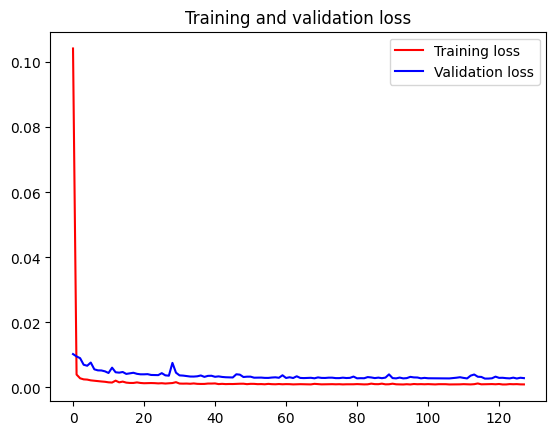

<Figure size 640x480 with 0 Axes>

In [35]:
loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

Kode ini mengekstrak nilai loss (kerugian) dari proses training (loss) dan validasi (val_loss) yang tersimpan dalam objek history_lstm, kemudian membuat visualisasi perbandingan keduanya menggunakan matplotlib dengan sumbu x menunjukkan jumlah epoch (iterasi training) dan sumbu y menunjukkan nilai loss, dimana garis merah ('r') merepresentasikan training loss yang menunjukkan seberapa baik model belajar dari data latih, sementara garis biru ('b') menunjukkan validation loss yang mengindikasikan kemampuan generalisasi model pada data baru, dengan penambahan judul grafik ('Training and validation loss') dan legend untuk memudahkan interpretasi, sehingga kita bisa mengevaluasi apakah model mengalami underfitting/overfitting.
<br>

Berdasarkan pola kedua kurva tersebut dan menentukan titik optimal dimana validasi loss mulai menurun (indikasi goodfit) dengan training loss terus menurun.

Lakukan prediksi dan periksa Performence metrics

In [36]:
train_predict_lstm=model_lstm.predict(X_train_lstm)
test_predict_lstm=model_lstm.predict(X_test_lstm)
train_predict_lstm.shape, test_predict_lstm.shape

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


((789, 1), (189, 1))

Kode tersebut digunakan untuk melakukan prediksi menggunakan model LSTM yang telah dilatih. Baris pertama menghasilkan prediksi terhadap data latih (X_train_lstm) dan menyimpannya ke dalam variabel train_predict_lstm, sedangkan baris kedua menghasilkan prediksi terhadap data uji (X_test_lstm) dan menyimpannya ke dalam test_predict_lstm. Kedua variabel tersebut berisi hasil prediksi model dalam bentuk array berdimensi dua, di mana setiap baris mewakili satu prediksi nilai output. Baris terakhir menampilkan bentuk (shape) dari hasil prediksi untuk data latih dan data uji, yang biasanya berbentuk (jumlah_data, 1) karena model hanya menghasilkan satu nilai output untuk setiap input sequence.

Ubah kembali ke bentuk Original (Denormalisasi)

In [37]:
train_predict_lstm = scaler.inverse_transform(train_predict_lstm)
test_predict_lstm = scaler.inverse_transform(test_predict_lstm)
original_ytrain_lstm = scaler.inverse_transform(y_train_lstm.reshape(-1,1))
original_ytest_lstm = scaler.inverse_transform(y_test_lstm.reshape(-1,1))

Kode tersebut digunakan untuk mengembalikan data hasil prediksi dan data asli ke skala aslinya sebelum dilakukan normalisasi (proses inverse transform). Karena data input sebelumnya telah dinormalisasi menggunakan scaler (MinMaxScaler), hasil prediksi dari model (train_predict_lstm dan test_predict_lstm) masih dalam bentuk nilai yang telah diskalakan. Oleh karena itu, scaler.inverse_transform() digunakan untuk mengubah hasil prediksi dan juga nilai target asli (y_train_lstm dan y_test_lstm) kembali ke skala harga sebenarnya. Proses reshape pada y_train_lstm dan y_test_lstm dilakukan agar bentuk array sesuai dengan format yang dibutuhkan oleh inverse_transform, yaitu dua dimensi (n_samples, 1). Hal ini penting agar evaluasi performa model bisa dilakukan secara akurat menggunakan nilai harga yang sesungguhnya.

## 2. CNN 1D

konversikan array nilai menjadi matriks kumpulan data kemudian tuning hyperparameter dan tampilkan history pelatihan modelnya, berlaku untuk 2 sel kebawah

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Create the dataset for CNN
def create_dataset_cnn(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset['Close'][i:(i + time_step)].values
        dataX.append(a)
        dataY.append(dataset['Close'].iloc[i + time_step])
    return np.array(dataX), np.array(dataY)

time_step = 10
X_train_cnn, y_train_cnn = create_dataset_cnn(train_data_scaled, time_step)
X_test_cnn, y_test_cnn = create_dataset_cnn(test_data_scaled, time_step)

# Reshape the input data for CNN (samples, time steps, features)
X_train_cnn = X_train_cnn.reshape(X_train_cnn.shape[0], X_train_cnn.shape[1], 1)
X_test_cnn = X_test_cnn.reshape(X_test_cnn.shape[0], X_test_cnn.shape[1], 1)

# Define the CNN model
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))  # Output layer for regression
model_cnn.compile(optimizer='adam', loss='mse')
model_cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 8, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │        12,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,157 (51.39 KB)

 Trainable params: 13,157 (51.39 KB)

 Non-trainable params: 0 (0.00 B)

Kode ini membangun model CNN (Convolutional Neural Network) untuk prediksi time series dengan terlebih dahulu mempersiapkan data menggunakan fungsi create_dataset_cnn yang mengubah deret waktu menjadi input-output berbasis sequence dengan time_step=10, kemudian melakukan reshape data menjadi format 3D [samples, time_steps, features] yang sesuai untuk input CNN. Model CNN terdiri dari lapisan Conv1D dengan 64 filter dan kernel size 3 untuk mengekstrak pola lokal dalam data, diikuti MaxPooling1D untuk reduksi dimensi, Flatten untuk mengubah output menjadi vektor, serta dua lapisan Dense (50 neuron dengan aktivasi ReLU dan 1 neuron output tanpa aktivasi untuk regresi) yang dikompilasi dengan optimizer Adam dan loss function MSE (Mean Squared Error). Arsitektur ini dirancang untuk menangkap pola spasial/temporal dalam data deret waktu dengan menganggap sequence sebagai "feature map" 1D yang dapat diproses oleh operasi konvolusi.

In [39]:
# Train the model
history_cnn = model_cnn.fit(X_train_cnn, y_train_cnn, epochs=128, batch_size=32, validation_data=(X_test_cnn, y_test_cnn), verbose=1)

Epoch 1/128
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.2249 - val_loss: 0.0295
Epoch 2/128
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0119 - val_loss: 0.0157
Epoch 3/128
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0106
Epoch 4/128
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0097
Epoch 5/128
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0092
Epoch 6/128
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0091
Epoch 7/128
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028 - val_loss: 0.0084
Epoch 8/128
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0029 - val_loss: 0.0078
Epoch 9/128
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0080
Epoch 10/128
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028 - val_loss: 0.0073
Epoch 11/128
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_loss: 0.0071
Epoch 12/128
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

Kode tersebut digunakan untuk melatih model CNN (model_cnn) menggunakan data latih (X_train_cnn, y_train_cnn) selama 128 epoch dengan batch size 32. Proses pelatihan ini juga memantau kinerja model terhadap data uji (X_test_cnn, y_test_cnn) sebagai data validasi untuk melihat apakah model mengalami overfitting atau tidak selama pelatihan. Parameter verbose=1 digunakan agar proses pelatihan ditampilkan secara rinci di konsol, termasuk nilai loss dan val_loss di setiap epoch. Hasil pelatihan disimpan dalam variabel history_cnn, yang dapat digunakan untuk memvisualisasikan atau menganalisis performa model dari waktu ke waktu.

Menampilkan Plotting Loss dan Validasi Loss

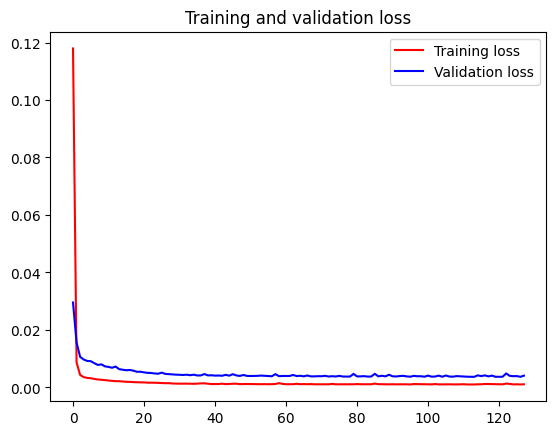

<Figure size 640x480 with 0 Axes>

In [40]:
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

Kode ini mengekstrak nilai loss (kerugian) dari proses training (loss) dan validasi (val_loss) yang tersimpan dalam objek history_cnn, kemudian membuat visualisasi perbandingan keduanya menggunakan matplotlib dengan sumbu x menunjukkan jumlah epoch (iterasi training) dan sumbu y menunjukkan nilai loss, dimana garis merah ('r') merepresentasikan training loss yang menunjukkan seberapa baik model belajar dari data latih, sementara garis biru ('b') menunjukkan validation loss yang mengindikasikan kemampuan generalisasi model pada data baru, dengan penambahan judul grafik ('Training and validation loss') dan legend untuk memudahkan interpretasi, sehingga kita bisa mengevaluasi apakah model mengalami underfitting/overfitting.
<br>

Berdasarkan pola kedua kurva tersebut dan menentukan titik optimal dimana validasi loss mulai menurun (indikasi goodfit) dengan training loss terus menurun.

Melakukan prediksi dan periksa Performence metrics

In [41]:
train_predict_cnn=model_cnn.predict(X_train_cnn)
test_predict_cnn=model_cnn.predict(X_test_cnn)
train_predict_cnn.shape, test_predict_cnn.shape

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


((789, 1), (189, 1))

Kode tersebut digunakan untuk melakukan prediksi menggunakan model cnn yang telah dilatih. Baris pertama menghasilkan prediksi terhadap data latih (X_train_cnn) dan menyimpannya ke dalam variabel train_predict_cnn, sedangkan baris kedua menghasilkan prediksi terhadap data uji (X_test_cnn) dan menyimpannya ke dalam test_predict_cnn. Kedua variabel tersebut berisi hasil prediksi model dalam bentuk array berdimensi dua, di mana setiap baris mewakili satu prediksi nilai output. Baris terakhir menampilkan bentuk (shape) dari hasil prediksi untuk data latih dan data uji, yang biasanya berbentuk (jumlah_data, 1) karena model hanya menghasilkan satu nilai output untuk setiap input sequence.

Ubah kembali ke bentuk Original (Denormalisasi)

In [42]:
train_predict_cnn = scaler.inverse_transform(train_predict_cnn)
test_predict_cnn = scaler.inverse_transform(test_predict_cnn)
original_ytrain_cnn = scaler.inverse_transform(y_train_cnn.reshape(-1,1))
original_ytest_cnn = scaler.inverse_transform(y_test_cnn.reshape(-1,1))

Kode tersebut digunakan untuk mengembalikan data hasil prediksi dan data asli ke skala aslinya sebelum dilakukan normalisasi (proses inverse transform). Karena data input sebelumnya telah dinormalisasi menggunakan scaler (MinMaxScaler), hasil prediksi dari model (train_predict_cnn dan test_predict_cnn) masih dalam bentuk nilai yang telah diskalakan. Oleh karena itu, scaler.inverse_transform() digunakan untuk mengubah hasil prediksi dan juga nilai target asli (y_train_cnn dan y_test_cnn) kembali ke skala harga sebenarnya. Proses reshape pada y_train_cnn dan y_test_cnn dilakukan agar bentuk array sesuai dengan format yang dibutuhkan oleh inverse_transform, yaitu dua dimensi (n_samples, 1). Hal ini penting agar evaluasi performa model bisa dilakukan secara akurat menggunakan nilai harga yang sesungguhnya.

## 3. GRU

konversikan array nilai menjadi matriks kumpulan data kemudian tuning hyperparameter dan tampilkan history pelatihan modelnya

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# Create the dataset for GRU
def create_dataset_gru(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset['Close'][i:(i + time_step)].values
        dataX.append(a)
        dataY.append(dataset['Close'].iloc[i + time_step])
    return np.array(dataX), np.array(dataY)

time_step = 10
X_train_gru, y_train_gru = create_dataset_gru(train_data_scaled, time_step)
X_test_gru, y_test_gru = create_dataset_gru(test_data_scaled, time_step)

# Reshape the input data for GRU (samples, time steps, features)
X_train_gru = X_train_gru.reshape(X_train_gru.shape[0],X_train_gru.shape[1] , 1)
X_test_gru = X_test_gru.reshape(X_test_gru.shape[0],X_test_gru.shape[1] , 1)

# Define the GRU model
model_gru = Sequential()
model_gru.add(GRU(100, input_shape=(X_train_gru.shape[1], 1), activation='relu')) # Adjust units as needed
model_gru.add(Dense(1))
model_gru.compile(optimizer='adam', loss='mse')

# Train the GRU model
history_gru = model_gru.fit(X_train_gru, y_train_gru, epochs=128, batch_size=16, validation_data=(X_test_gru,y_test_gru), verbose=1)

Epoch 1/128


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.3139 - val_loss: 0.0199
Epoch 2/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0066 - val_loss: 0.0053
Epoch 3/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - val_loss: 0.0050
Epoch 4/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - val_loss: 0.0046
Epoch 5/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - val_loss: 0.0049
Epoch 6/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - val_loss: 0.0054
Epoch 7/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014 - val_loss: 0.0045
Epoch 8/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - val_loss: 0.0044
Epoch 9/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 0.0043
Epoch 10/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 0.0041
Epoch 11/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - val_loss: 0.0040
Epoch 12/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 - val_l

Kode tersebut membangun dan melatih model GRU (Gated Recurrent Unit) menggunakan Keras untuk melakukan prediksi harga penutupan saham. Pertama, fungsi `create_dataset_gru` membuat dataset berdasarkan window waktu tertentu (`time_step=10`), yaitu dengan mengambil 10 data sebelumnya untuk memprediksi data berikutnya. Dataset hasil pemrosesan kemudian diubah bentuknya menjadi tiga dimensi agar sesuai dengan input yang dibutuhkan GRU: `(jumlah sampel, time steps, fitur)`.

Model GRU dibangun secara berurutan (`Sequential`) dengan satu layer GRU berisi 100 unit dan fungsi aktivasi ReLU, serta satu layer output Dense dengan satu neuron. Model dikompilasi menggunakan optimizer Adam dan loss function mean squared error (MSE), yang umum digunakan untuk masalah regresi. Pelatihan dilakukan selama 128 epoch dengan batch size 16 dan memantau performa pada data uji, sementara hasil pelatihan disimpan dalam `history_gru` untuk dianalisis lebih lanjut.

Menampilkan Plotting Loss and Validation Loss

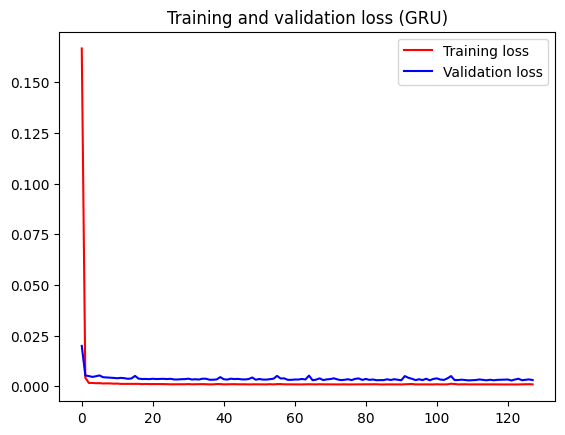

In [44]:
loss = history_gru.history['loss']
val_loss = history_gru.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (GRU)')
plt.legend()
plt.show()

Kode ini mengekstrak nilai loss (kerugian) dari proses training (loss) dan validasi (val_loss) yang tersimpan dalam objek history_gru, kemudian membuat visualisasi perbandingan keduanya menggunakan matplotlib dengan sumbu x menunjukkan jumlah epoch (iterasi training) dan sumbu y menunjukkan nilai loss, dimana garis merah ('r') merepresentasikan training loss yang menunjukkan seberapa baik model belajar dari data latih, sementara garis biru ('b') menunjukkan validation loss yang mengindikasikan kemampuan generalisasi model pada data baru, dengan penambahan judul grafik ('Training and validation loss') dan legend untuk memudahkan interpretasi, sehingga kita bisa mengevaluasi apakah model mengalami underfitting/overfitting.
<br>

Berdasarkan pola kedua kurva tersebut dan menentukan titik optimal dimana validasi loss mulai menurun (indikasi goodfit) dengan training loss terus menurun.

Melakukan prediksi dan Denormalisasi

In [45]:
# Make predictions
train_predict_gru = model_gru.predict(X_train_gru)
test_predict_gru = model_gru.predict(X_test_gru)

# Inverse transform the predictions and actual values
train_predict_gru = scaler.inverse_transform(train_predict_gru)
test_predict_gru = scaler.inverse_transform(test_predict_gru)
original_ytrain_gru = scaler.inverse_transform(y_train_gru.reshape(-1,1))
original_ytest_gru = scaler.inverse_transform(y_test_gru.reshape(-1,1))

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


Kode tersebut digunakan untuk menghasilkan prediksi harga dari model GRU yang telah dilatih, serta mengembalikan nilai prediksi dan nilai aktual ke skala aslinya. Pertama, model melakukan prediksi terhadap data latih (`X_train_gru`) dan data uji (`X_test_gru`), lalu hasil prediksi tersebut disimpan dalam `train_predict_gru` dan `test_predict_gru`. Karena data sebelumnya telah dinormalisasi menggunakan `scaler` (MinMaxScaler), maka fungsi `inverse_transform()` digunakan untuk mengubah hasil prediksi serta data target asli (`y_train_gru` dan `y_test_gru`) kembali ke bentuk harga sebenarnya. Reshape dilakukan pada `y_train_gru` dan `y_test_gru` agar sesuai dengan format dua dimensi yang dibutuhkan oleh `inverse_transform`, sehingga hasil evaluasi dan visualisasi dapat mencerminkan nilai riil dari harga penutupan saham.

# E. Evaluasi Model

## 1. Evaluasi Model LSTM

In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def mean_absolute_percentage_error_lstm(y_true_lstm, y_pred_lstm):
    y_true_lstm, y_pred_lstm = np.array(y_true_lstm), np.array(y_pred_lstm)
    return np.mean(np.abs((y_true_lstm - y_pred_lstm) / y_true_lstm)) * 100

# Hitung Metrik Evaluasi untuk Data Training LSTM
mse_train_lstm = mean_squared_error(original_ytrain_lstm, train_predict_lstm)
rmse_train_lstm = np.sqrt(mse_train_lstm)
mae_train_lstm = mean_absolute_error(original_ytrain_lstm, train_predict_lstm)
mape_train_lstm = mean_absolute_percentage_error_lstm(original_ytrain_lstm, train_predict_lstm)
r2_train_lstm = r2_score(original_ytrain_lstm, train_predict_lstm)

# Hitung Metrik Evaluasi untuk Data Testing LSTM
mse_test_lstm = mean_squared_error(original_ytest_lstm, test_predict_lstm)
rmse_test_lstm = np.sqrt(mse_test_lstm)
mae_test_lstm = mean_absolute_error(original_ytest_lstm, test_predict_lstm)
mape_test_lstm = mean_absolute_percentage_error_lstm(original_ytest_lstm, test_predict_lstm)
r2_test_lstm = r2_score(original_ytest_lstm, test_predict_lstm)

print("Training Data Metrics LSTM:")
print(f"MSE: {mse_train_lstm:.2f}")
print(f"RMSE: {rmse_train_lstm:.2f}")
print(f"MAE: {mae_train_lstm:.2f}")
print(f"MAPE: {mape_train_lstm:.2f}%")
print(f"R-squared: {r2_train_lstm:.2f}")

print("\nTesting Data Metrics LSTM:")
print(f"MSE: {mse_test_lstm:.2f}")
print(f"RMSE: {rmse_test_lstm:.2f}")
print(f"MAE: {mae_test_lstm:.2f}")
print(f"MAPE: {mape_test_lstm:.2f}%")
print(f"R-squared: {r2_test_lstm:.2f}")


Training Data Metrics LSTM:
MSE: 2492.08
RMSE: 49.92
MAE: 38.85
MAPE: 0.57%
R-squared: 0.98

Testing Data Metrics LSTM:
MSE: 7978.20
RMSE: 89.32
MAE: 66.26
MAPE: 0.95%
R-squared: 0.96


## 2. Evaluasi Model CNN 1D

In [47]:
def mean_absolute_percentage_error_cnn(y_true_cnn, y_pred_cnn):
    y_true_cnn, y_pred_cnn = np.array(y_true_cnn), np.array(y_pred_cnn)
    return np.mean(np.abs((y_true_cnn - y_pred_cnn) / y_true_cnn)) * 100

# Hitung metrik untuk data training CNN
mse_train_cnn = mean_squared_error(original_ytrain_cnn, train_predict_cnn)
rmse_train_cnn = np.sqrt(mse_train_cnn)
mae_train_cnn = mean_absolute_error(original_ytrain_cnn, train_predict_cnn)
mape_train_cnn = mean_absolute_percentage_error_cnn(original_ytrain_cnn, train_predict_cnn)
r2_train_cnn = r2_score(original_ytrain_cnn, train_predict_cnn)

# Hitung metrik untuk data testing CNN
mse_test_cnn = mean_squared_error(original_ytest_cnn, test_predict_cnn)
rmse_test_cnn = np.sqrt(mse_test_cnn)
mae_test_cnn = mean_absolute_error(original_ytest_cnn, test_predict_cnn)
mape_test_cnn = mean_absolute_percentage_error_cnn(original_ytest_cnn, test_predict_cnn)
r2_test_cnn = r2_score(original_ytest_cnn, test_predict_cnn)

print("\nTraining Data Metrics CNN:")
print(f"MSE: {mse_train_cnn:.4f}")
print(f"RMSE: {rmse_train_cnn:.4f}")
print(f"MAE: {mae_train_cnn:.4f}")
print(f"MAPE: {mape_train_cnn:.2f}%")
print(f"R-squared: {r2_train_cnn:.4f}")

print("\nTesting Data Metrics CNN:")
print(f"MSE: {mse_test_cnn:.4f}")
print(f"RMSE: {rmse_test_cnn:.4f}")
print(f"MAE: {mae_test_cnn:.4f}")
print(f"MAPE: {mape_test_cnn:.2f}%")
print(f"R-squared: {r2_test_cnn:.4f}")


Training Data Metrics CNN:
MSE: 3126.6025
RMSE: 55.9160
MAE: 43.6916
MAPE: 0.64%
R-squared: 0.9791

Testing Data Metrics CNN:
MSE: 11399.8232
RMSE: 106.7700
MAE: 83.3281
MAPE: 1.18%
R-squared: 0.9408


## 3. Evaluasi Model GRU

In [48]:
def mean_absolute_percentage_error_gru(y_true_gru, y_pred_gru):
    y_true_gru, y_pred_gru = np.array(y_true_gru), np.array(y_pred_gru)
    return np.mean(np.abs((y_true_gru - y_pred_gru) / y_true_gru)) * 100

# Hitung Metrik Evaluasi untuk Data Training GRU
mse_train_gru = mean_squared_error(original_ytrain_gru, train_predict_gru)
rmse_train_gru = np.sqrt(mse_train_gru)
mae_train_gru = mean_absolute_error(original_ytrain_gru, train_predict_gru)
mape_train_gru = mean_absolute_percentage_error_gru(original_ytrain_gru, train_predict_gru)
r2_train_gru = r2_score(original_ytrain_gru, train_predict_gru)

# Hitung Metrik Evaluasi untuk Data Testing GRU
mse_test_gru = mean_squared_error(original_ytest_gru, test_predict_gru)
rmse_test_gru = np.sqrt(mse_test_gru)
mae_test_gru = mean_absolute_error(original_ytest_gru, test_predict_gru)
mape_test_gru = mean_absolute_percentage_error_gru(original_ytest_gru, test_predict_gru)
r2_test_gru = r2_score(original_ytest_gru, test_predict_gru)

print("\nTraining Data Metrics GRU:")
print(f"MSE: {mse_train_gru:.2f}")
print(f"RMSE: {rmse_train_gru:.2f}")
print(f"MAE: {mae_train_gru:.2f}")
print(f"MAPE: {mape_train_gru:.2f}%")
print(f"R-squared: {r2_train_gru:.2f}")

print("\nTesting Data Metrics GRU:")
print(f"MSE: {mse_test_gru:.2f}")
print(f"RMSE: {rmse_test_gru:.2f}")
print(f"MAE: {mae_test_gru:.2f}")
print(f"MAPE: {mape_test_gru:.2f}%")
print(f"R-squared: {r2_test_gru:.2f}")


Training Data Metrics GRU:
MSE: 2513.77
RMSE: 50.14
MAE: 38.85
MAPE: 0.57%
R-squared: 0.98

Testing Data Metrics GRU:
MSE: 8588.93
RMSE: 92.68
MAE: 70.07
MAPE: 1.00%
R-squared: 0.96


## 4. Kesimpulan

In [49]:
# membuat kamus berdasarkan hasil
results = {
    'Model': ['LSTM', 'CNN', 'GRU'],
    'MSE_Train': [mse_train_lstm, mse_train_cnn, mse_train_gru],
    'RMSE_Train': [rmse_train_lstm, rmse_train_cnn, rmse_train_gru],
    'MAE_Train': [mae_train_lstm, mae_train_cnn, mae_train_gru],
    'MAPE_Train': [mape_train_lstm, mape_train_cnn, mape_train_gru],
    'R2_Train': [r2_train_lstm, r2_train_cnn, r2_train_gru],
    'MSE_Test': [mse_test_lstm, mse_test_cnn, mse_test_gru],
    'RMSE_Test': [rmse_test_lstm, rmse_test_cnn, rmse_test_gru],
    'MAE_Test': [mae_test_lstm, mae_test_cnn, mae_test_gru],
    'MAPE_Test': [mape_test_lstm, mape_test_cnn, mape_test_gru],
    'R2_Test': [r2_test_lstm, r2_test_cnn, r2_test_gru],
}

# Membuat dataframe berasarkan result(hasil)
df_results = pd.DataFrame(results)
print(df_results)

# Sortir berdasarkan R2
df_results_sorted = df_results.sort_values(by=['MSE_Test', 'R2_Test'], ascending=[True, True])
print("\nModel terbaik berdasarkan Evaluasi:")
df_results_sorted

  Model    MSE_Train  RMSE_Train  MAE_Train  MAPE_Train  R2_Train  \
0  LSTM  2492.075914   49.920696  38.845927    0.574054  0.983346   
1   CNN  3126.602476   55.916031  43.691587    0.643636  0.979105   
2   GRU  2513.770906   50.137520  38.854945    0.574631  0.983201   

       MSE_Test   RMSE_Test   MAE_Test  MAPE_Test   R2_Test  
0   7978.197943   89.320759  66.263884   0.948856  0.958567  
1  11399.823241  106.769955  83.328097   1.183736  0.940797  
2   8588.933387   92.676499  70.069656   0.999125  0.955395  

Model terbaik berdasarkan Evaluasi:


,Model,MSE_Train,RMSE_Train,MAE_Train,MAPE_Train,R2_Train,MSE_Test,RMSE_Test,MAE_Test,MAPE_Test,R2_Test
0,LSTM,2492.075914,49.920696,38.845927,0.574054,0.983346,7978.197943,89.320759,66.263884,0.948856,0.958567
2,GRU,2513.770906,50.137520,38.854945,0.574631,0.983201,8588.933387,92.676499,70.069656,0.999125,0.955395
1,CNN,3126.602476,55.916031,43.691587,0.643636,0.979105,11399.823241,106.769955,83.328097,1.183736,0.940797


**Berdasarkan Hasil Evaluasi Model, LSTM merupakan Model Terbaik untuk studi kasus Time Series univariate**

**ALASAN LSTM MENJADI MODEL TERBAIK KARENA SKOR MSE UNTUK DATA TRAIN DAN DATA TEST MENJADI YANG TERKECIL SEPERTI PADA TABEL DIATAS, LALU SKOR RMSE UNTUK KEDUA DATA JUGA MENJADI YANG TERKECIL DARI KEDUA MODEL LAINNYA, LALU UNTUK MAE DATA TRAIN DAN DATA TEST LSTM UNGGUL DARI KEDUA MODEL LAINNYA DENGAN MENJADI MODEL DENGAN SKOR TERKECIL, UNTUK MAPE DARI KEDUA DATA LSTM UNGGUL DARI KEDUA MODEL LAINNYA, DAN TERAKHIR UNTUK SKOR R2 LSTM LAH YANG PALING UNGGUL DARI KEDUA MODEL LAINNYA DENGAN SKOR R2 PALING MENDEKATI 1.**

Maka dari itu Model **LSTM** yang akan dipilih untuk dijadikan implementasi.

# F. Implementasi

Simpan Model:

In [50]:
import tensorflow as tf

# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model_lstm) # Change to model_lstm

# Enable resource variables (if needed)
converter.experimental_enable_resource_variables = True

# Set supported ops to include Select TF ops (if needed)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS
]

tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('lstm_model.tflite', 'wb') as f:  # Change filename
    f.write(tflite_model)

Saved artifact at '/tmp/tmpg6ukau0c'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132766212728464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132766212733840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132766212734800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132766212732688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132766212729616: TensorSpec(shape=(), dtype=tf.resource, name=None)


Data Sebelum dan Sesudah Prediksi:

In [51]:
import plotly.express as px
from itertools import cycle

look_back = time_step

train_predict_plot = np.empty_like(maindf_cleaned_split[['Close']])
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict_lstm) + look_back, :] = train_predict_lstm
print("Train predicted data: ", train_predict_plot.shape)

test_predict_plot = np.empty_like(maindf_cleaned_split[['Close']])
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict_lstm) + (look_back * 2) + 1:len(maindf_cleaned_split[['Close']]) - 1, :] = test_predict_lstm
print("Test predicted data: ", test_predict_plot.shape)

plotdf = pd.DataFrame({'Date': maindf_cleaned_split.index,
                       'original_close': maindf_cleaned_split['Close'],
                       'train_predicted_close': train_predict_plot.reshape(1, -1)[0].tolist(),
                       'test_predicted_close': test_predict_plot.reshape(1, -1)[0].tolist()})


names = cycle(['Data Harga Asli', 'Data Harga(berdsasarkan data latih)', 'Data Harga(berdsasarkan data Uji)'])

fig = px.line(plotdf, x=plotdf['Date'], y=[plotdf['original_close'], plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value': 'Harga IHSG(^JKSE)', 'Date': 'Tanggal'})
fig.update_layout(title_text='Komparasi dari Harga Penutupan asli dengan Harga Penutupan Hasil Prediksi',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t: t.update(name=next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (1000, 1)
Test predicted data:  (1000, 1)


Contoh penggunaan untuk prediksi 7 hari kedepan:

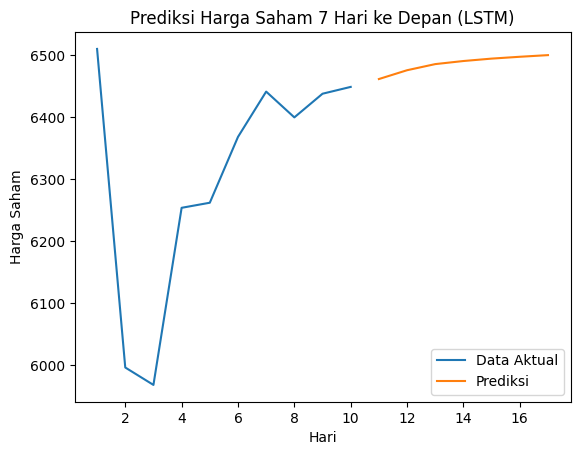

In [52]:
# Predict the next 7 days using LSTM
x_input = test_data_scaled[-10:].values  # Taking the last 10 days' data
x_input = x_input.reshape(1, -1, 1)  # Reshaping for LSTM input

temp_input = list(x_input[0].flatten())
lst_output = []
n_steps = 10

i = 0
while i < 7:
    if len(temp_input) > 10:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1, 1)
        yhat = model_lstm.predict(x_input, verbose=0)  # Using model_lstm for prediction
        temp_input.extend(yhat[0].flatten().tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model_lstm.predict(x_input, verbose=0)  # Using model_lstm for prediction
        temp_input.extend(yhat[0].flatten().tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

day_new = np.arange(1, 11)
day_pred = np.arange(11, 18)

plt.plot(day_new, scaler.inverse_transform(test_data_scaled[-10:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))
plt.title('Prediksi Harga Saham 7 Hari ke Depan (LSTM)')  # Updated title
plt.xlabel('Hari')
plt.ylabel('Harga Saham')
plt.legend(['Data Aktual', 'Prediksi'])
plt.show()

In [53]:
!pip freeze > requirements.txt